In [27]:
import scipy
import seaborn as sns

from api.instance import Instance
from strategies.local_search.local_search import LocalSearch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set()

def solution_similarity_vertex(s1, s2):
    return len((set(s1)&set(s2)))/(len(s1)-1)

def solution_similarity_edge(s1, s2):
    sim = 0
    edges_s1, edges_s2 = [], []
    for s in range(len(s1)-1):
        edges_s1.append((s1[s], s1[s+1]))
        edges_s2.append((s2[s], s2[s+1]))
    for s in edges_s1:
        if s in edges_s2 or s[::-1] in edges_s2:
            sim += 1
    return sim/(len(s1)-1)


100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s]


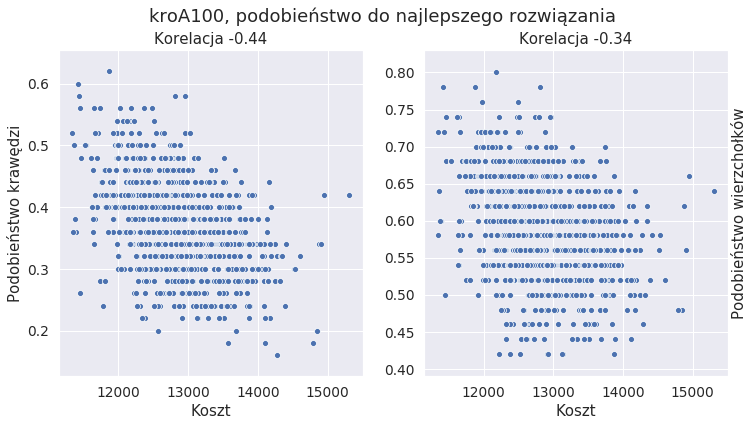

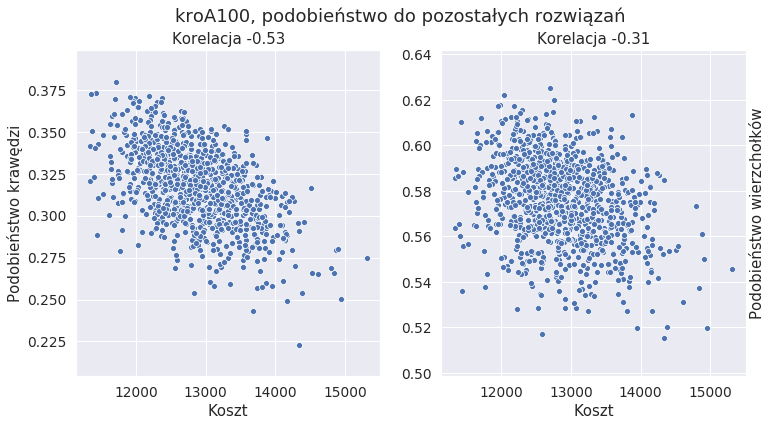

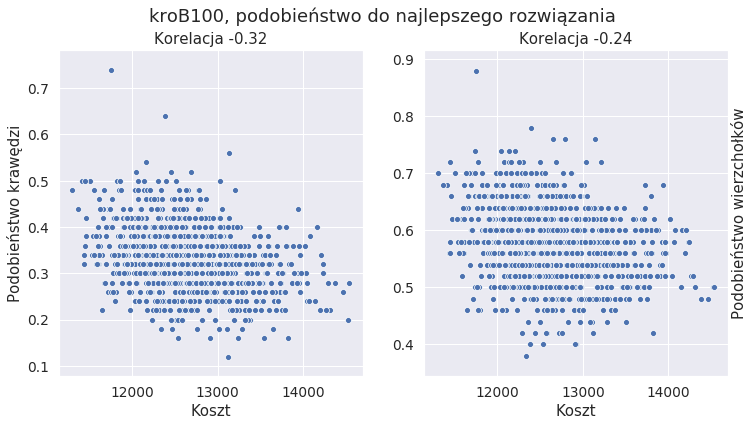

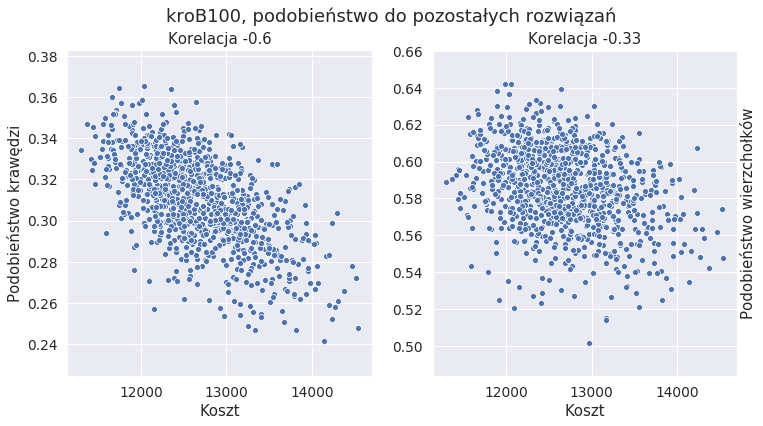

In [28]:
# for instance_name in ['kroA100','kroA200','kroB100','kroB200']:
for instance_name in ['kroA100','kroB100']:
    df = pd.DataFrame(columns=['solution', 'cost', 'time'], dtype="float")
    instance = Instance(name=instance_name)
    solve_strategy: LocalSearch = LocalSearch(
        instance=instance,
        version="greedy",
        neighbourhood="edge",
    )
    solve_strategy.run(run_times=1000)

    for s, cost, time in solve_strategy.solutions:
        df = df.append(pd.DataFrame([[s, cost, time]],columns=['solution', 'cost', 'time'], dtype="float"))

    df = df.reset_index()
    best_solution = df.iloc[df['cost'].idxmin(axis=0)]['solution']
    df.drop(df['cost'].idxmin(), inplace=True)
    results_vertex = []
    results_edge = []
    for sol in df.iterrows():
        results_vertex.append([sol[1]['cost'], solution_similarity_vertex(sol[1]['solution'], best_solution)])
        results_edge.append([sol[1]['cost'], solution_similarity_edge(sol[1]['solution'], best_solution)])


    np_edge = np.asarray(results_edge)
    np_vertex = np.asarray(results_vertex)

    corr_edge, _ = scipy.stats.pearsonr(np_edge[:, 0], np_edge[:, 1])
    corr_vertex, _ = scipy.stats.pearsonr(np_vertex[:, 0], np_vertex[:, 1])

    df_edge = pd.DataFrame({'Koszt': np_edge[:, 0], 'Podobieństwo krawędzi': np_edge[:, 1]})
    df_vertex = pd.DataFrame({'Koszt': np_vertex[:, 0], 'Podobieństwo wierzchołków': np_vertex[:, 1]})


    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    fig, ax =plt.subplots(1,2,figsize=(12,6))

    sns.scatterplot(data=df_edge, x='Koszt',y='Podobieństwo krawędzi',ax=ax[0])
    sns.scatterplot(data=df_vertex, x='Koszt',y='Podobieństwo wierzchołków',ax=ax[1])
    ax[0].set_title(f'Korelacja {round(corr_edge,2)}')
    ax[1].set_title(f'Korelacja {round(corr_vertex,2)}')
    ax[1].yaxis.set_label_position("right")


    plt.suptitle(f'{instance_name}, podobieństwo do najlepszego rozwiązania')
    plt.savefig(instance_name+'one.jpg')

    results_vertex_all = []
    results_edge_all = []

    for sol in df.iterrows():
        partial_vertex, partial_edge = 0, 0
        for s in df.iterrows():
            partial_vertex += solution_similarity_vertex(sol[1]['solution'], s[1]['solution'])
            partial_edge += solution_similarity_edge(sol[1]['solution'], s[1]['solution'])
        partial_edge /= len(df)
        partial_vertex /= (len(df)-1)
        results_vertex_all.append([sol[1]['cost'], partial_vertex])
        results_edge_all.append([sol[1]['cost'], partial_edge])

    np_edge_all = np.asarray(results_edge_all)
    np_vertex_all = np.asarray(results_vertex_all)

    corr_edge, _ = scipy.stats.pearsonr(np_edge_all[:, 0], np_edge_all[:, 1])
    corr_vertex, _ = scipy.stats.pearsonr(np_vertex_all[:, 0], np_vertex_all[:, 1])

    df_edge = pd.DataFrame({'Koszt': np_edge_all[:, 0], 'Podobieństwo krawędzi': np_edge_all[:, 1]})
    df_vertex = pd.DataFrame({'Koszt': np_vertex_all[:, 0], 'Podobieństwo wierzchołków': np_vertex_all[:, 1]})

    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    fig, ax =plt.subplots(1,2,figsize=(12,6))

    sns.scatterplot(data=df_edge, x='Koszt',y='Podobieństwo krawędzi',ax=ax[0])
    sns.scatterplot(data=df_vertex, x='Koszt',y='Podobieństwo wierzchołków',ax=ax[1])
    ax[0].set_title(f'Korelacja {round(corr_edge,2)}')
    ax[1].set_title(f'Korelacja {round(corr_vertex,2)}')
    ax[1].yaxis.set_label_position("right")


    plt.suptitle(f'{instance_name}, podobieństwo do pozostałych rozwiązań')
    plt.savefig(instance_name+'all.jpg')